# Comparação de Modelo de Redes Neurais com LTSM e Polarity Scores do VADER

Uma lista de tweets, com seus sentimentos já classificados é treinada para a criação de um modelo de RNN com LTSM Bidirecional. Os resultados desse modelo são comparados com a Acurácia obtida pela função Polarity Scores do Vader.

### Importação dos dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import nltk

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, SpatialDropout1D, Embedding, Bidirectional
from keras.metrics import AUC
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")

sns.set()
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\andrr\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Obtendo o dataset
dados_tweets = pd.read_csv(r'..\Datasets\tweets2.csv', index_col=0)

In [3]:
# Verificando a presença de dados sem texto
dados_tweets.isna().sum()

id             0
local          0
sentiment      0
text         686
dtype: int64

In [4]:
# Retirando-os do dataset
dados_tweets = dados_tweets.dropna()

In [5]:
# Distribuição dos sentimentos
dados_tweets['sentiment'].value_counts()

sentiment
Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64

In [6]:
# Os tweets de sentimento "Irrelevante" serão retirados da base
dados_tweets = dados_tweets.loc[dados_tweets['sentiment']!='Irrelevant']

## Aplicação de Rede Neural (LTSM Bidirecional)


#### Tratamento dos Dados

In [7]:
# Tokenizando o corpus
token = Tokenizer(num_words=15000)
token.fit_on_texts(dados_tweets.text.values)

# Verificando o numero de palavras, para ver se o num_words definido esta adequado
print(f'Número de Palavras distintas:',len(token.word_index))

# Transformando os textos dos tweets
X = token.texts_to_sequences(dados_tweets.text.values)

Número de Palavras distintas: 29228


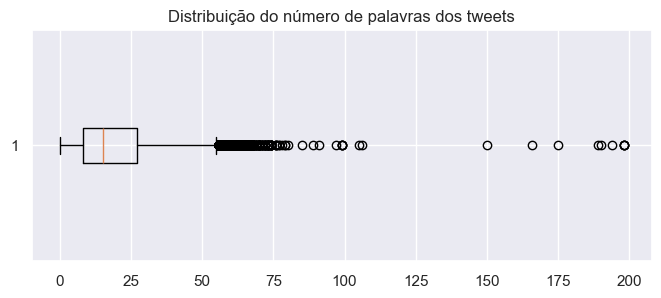

In [8]:
# Verifificando a distribuição do número de palavras dos tweets
plt.figure(figsize=(8,3))
plt.title('Distribuição do número de palavras dos tweets')
plt.boxplot((dados_tweets['text'].str.split().apply(lambda x: len(x))), vert=False)
plt.show()

Como podemos observar, o 3o quartil tem um valor levemente superior à 25, portanto, o valor selecionado para o maxlen será de 30 palavras.

In [9]:
# "Completando" tokens
X = pad_sequences(X, padding="post", maxlen=30)

In [10]:
# Obtendo dummies
y = pd.get_dummies(dados_tweets['sentiment']).values

In [11]:
# Separacao entre treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = .3, random_state=42)

#### Criação do Modelo

In [12]:
# Obtendo as recorrências das classes no dataset de treino
y_treino_classes = np.argmax(y_treino, axis=1)  

# Calculando os pesos das classes (serão necessarios para o modelo)
class_weights = compute_class_weight('balanced', classes=np.unique(y_treino_classes), y=y_treino_classes)
class_weight_dict = dict(enumerate(class_weights))

In [13]:
# Iniciando o modelo
model = Sequential()
model.add(Embedding(len(token.word_index) + 1, 250, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(150, dropout=0.2, recurrent_dropout=0.1)))
model.add(Dense(150, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(Dense(y_treino.shape[1], activation='softmax'))

In [16]:
# Compilando o modelo (learning rate diferente inferior ao padráo)
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=.001),
              metrics=['accuracy', AUC(name="auc")])

# Estrutura do modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 30, 250)             │       7,307,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 30, 250)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 300)                 │         481,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 150)                 │          45,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           7,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,841,303 (29.91 MB)

 Trainable params: 7,841,303 (29.91 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Definindo a parada adiantada (interrompe o treinamento se 'val_loss' não melhorar nas últimas 3 épocas, restaurando os melhores pesos)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Treinamento com pesos das classes
model.fit(X_treino,
          y_treino,
          epochs=20,
          batch_size=256,
          class_weight=class_weight_dict,
          validation_data=(X_teste, y_teste),
          callbacks=[early_stopping])

Epoch 1/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 39s 206ms/step - accuracy: 0.5000 - auc: 0.6820 - loss: 3.6176 - val_accuracy: 0.7605 - val_auc: 0.9056 - val_loss: 0.7316
Epoch 2/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 34s 204ms/step - accuracy: 0.8123 - auc: 0.9360 - loss: 0.5938 - val_accuracy: 0.8289 - val_auc: 0.9482 - val_loss: 0.4973
Epoch 3/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 34s 204ms/step - accuracy: 0.8802 - auc: 0.9712 - loss: 0.3841 - val_accuracy: 0.8534 - val_auc: 0.9603 - val_loss: 0.4327
Epoch 4/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 34s 202ms/step - accuracy: 0.9041 - auc: 0.9813 - loss: 0.3145 - val_accuracy: 0.8631 - val_auc: 0.9645 - val_loss: 0.4127
Epoch 5/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 34s 203ms/step - accuracy: 0.9179 - auc: 0.9863 - loss: 0.2690 - val_accuracy: 0.8763 - val_auc: 0.9683 - val_loss: 0.3818
Epoch 6/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 34s 203ms/step - accuracy: 0.9273 - auc: 0.9885 - loss: 0.2420 - val_accuracy: 0.8801 - val_auc: 0.9697 - val_loss: 0.3813
Epoch 7/20
168/168 ━━━

In [18]:
# Previsoes do modelo
y_pred_prob = model.predict(X_teste)

574/574 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step


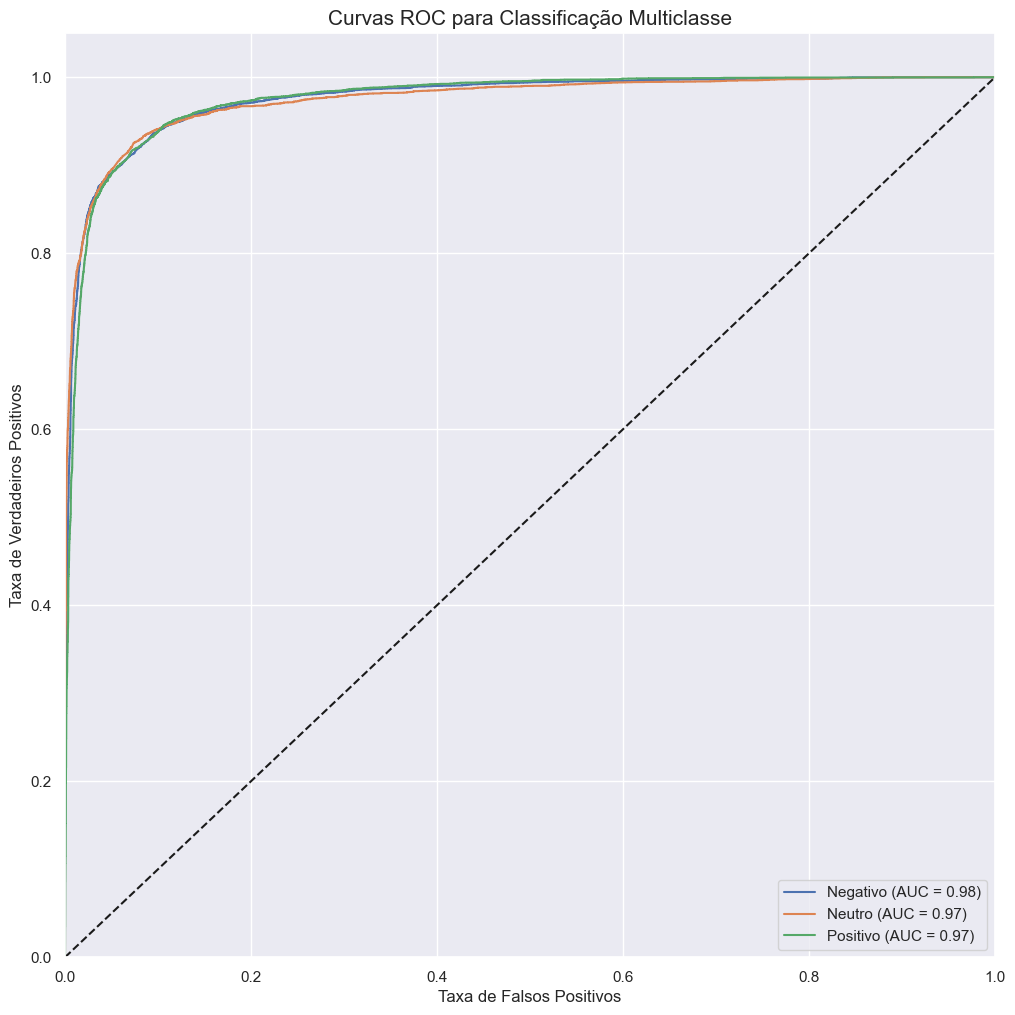

In [19]:
# Plotando as curvas ROC
y_true = y_teste  # classes verdadeiras 
y_scores = y_pred_prob  # probabilidades preditas pelo modelo
n_classes = y_treino.shape[1]

# Inicialize a figura
plt.figure(figsize=(12,12))

# Dicionário de classes
class_labels = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}

# curva ROC de cada classe
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

# Configurações do gráfico
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curvas ROC para Classificação Multiclasse', size=15)
plt.legend(loc='lower right')
plt.show()

In [20]:
# Verificando a Acurácia (Métrica que será utilizada para a comparação)
loss, acc, auc_val = model.evaluate(X_teste, y_teste, verbose=1)
print(f'Acurácia:', round((acc*100),2), '%')

574/574 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8925 - auc: 0.9734 - loss: 0.3493
Acurácia: 89.41 %


## VADER

Obtenção dos valores de *compound* e classificação dos tweets.

In [21]:
# Instanciando objeto
sia = SentimentIntensityAnalyzer()

In [22]:
# Criando coluna para a adicao do coumpound VADER
dados_tweets['vader_compound'] = ''

# Retornando o valor de COMPOUND da função polarity scores
dados_tweets['vader_compound'] = dados_tweets['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [23]:
# Criando coluna para a adicao do sentimento obtido atraves do compound
dados_tweets['vader_sentiment'] = 'Neutral'

# Se o valor final de compound for inferior a -0.05 o sentimento será negativo, se for superior a 0.05 será positivo, o resto será neutro
dados_tweets['vader_sentiment'].loc[dados_tweets['vader_compound']<-0.05] = 'Negative'
dados_tweets['vader_sentiment'].loc[dados_tweets['vader_compound']>0.05] = 'Positive'

In [24]:
# Obtendo series com os sentimentos de teste e os previstos
y_teste2 = dados_tweets['sentiment']
y_pred2 = dados_tweets['vader_sentiment']

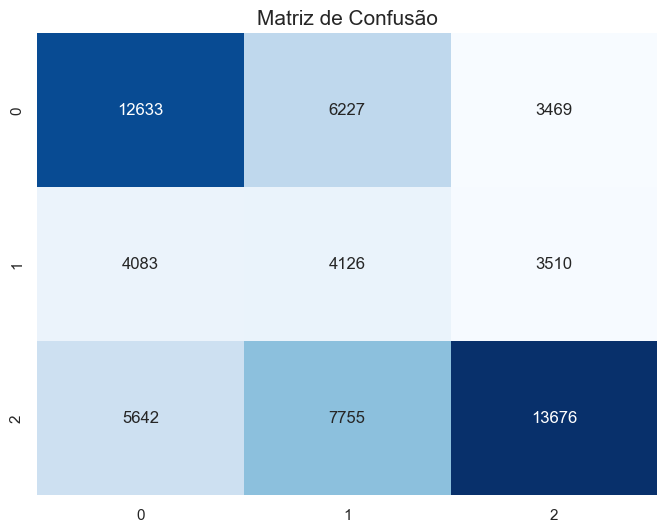

In [25]:
# Representação Gráfica da Matriz de confusao
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_pred2, y_teste2),
            annot=True, fmt='d', cmap='Blues',
            cbar=False)
plt.title('Matriz de Confusão', size=15)
plt.show()

In [26]:
# Verificando a Acurácia (Métrica que será utilizada para a comparação)
print(f'Acurácia:', round(accuracy_score(y_pred2, y_teste2),2), '%')

Acurácia: 0.5 %


***

### Análise de Resultados

A análise comparativa dos métodos de classificação de sentimentos revelou uma discrepância significativa nos resultados. O modelo de rede neural recorrente (RNN), utilizando LSTM bidirecional, alcançou uma acurácia de 88%, demonstrando sua eficácia na tarefa de classificação de sentimentos em tweets. Por outro lado, o método tradicional de análise de sentimentos VADER, com base no polarity_scores, obteve uma acurácia de apenas 0,5%, indicando uma performance muito inferior em relação à RNN. Isso destaca a superioridade do modelo de deep learning para esse tipo de problema.